In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
M = 10000
(x_train, _), (x_test, _) = mnist('./data')
x_train_generator = generator(x_train, M)

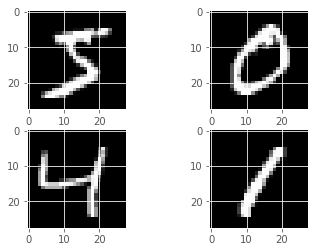

In [3]:
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(x_train_generator[0][i,:].reshape(28,28),cmap = 'gray')
plt.show()

In [4]:
sess = tf.InteractiveSession()
def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.matmul(h,W_decode) + b_decode
    return h

In [5]:
W_encode = Normal(loc = tf.zeros([28*28, 256]), scale = tf.ones([28*28, 256]))
W_decode = Normal(loc = tf.zeros([256, 28*28]), scale = tf.ones([256,28*28]))
b_encode = Normal(loc = tf.zeros(256), scale = tf.ones(256))
b_decode = Normal(loc = tf.zeros(28*28), scale = tf.ones(28*28))

x = tf.placeholder(tf.float32, [None, 28 * 28])

x_reconstruct = Bernoulli(logits=auto_encoder(x, W_encode, W_decode, b_encode, b_decode))


In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([28*28,256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,256]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([256,28*28])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,28*28]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([256])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([28*28])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28]))))


In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


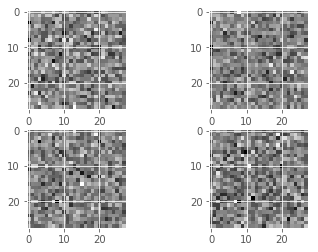

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()


In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode}, data = {x: x_train, x_reconstruct: x_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 10
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
6/6 [100%] ██████████████████████████████ Elapsed: 72s
-log p(x) <= -58097117577.216
Epoch: 2
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= -531787827153.032
Epoch: 3
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= -1759183850997.896
Epoch: 4
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= -3997884372344.286
Epoch: 5
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= -7478771075863.893
Epoch: 6
6/6 [100%] ██████████████████████████████ Elapsed: 64s
-log p(x) <= -12404025466796.986
Epoch: 7
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= -18964435253766.824
Epoch: 8
6/6 [100%] ██████████████████████████████ Elapsed: 66s
-log p(x) <= -27318501408785.477
Epoch: 9
6/6 [100%] ██████████████████████████████ Elapsed: 65s
-log p(x) <= -37566164528022.602
Epoch: 10
6/6 [100%] ██████████████████████████████ Elapsed: 66s
-log p(x) <= -49826791774224.383


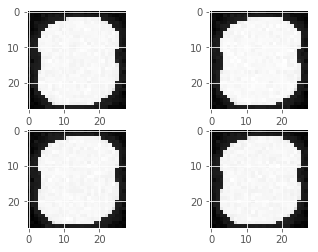

In [11]:
out = sess.run(reconstruct, feed_dict={x: x_train})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
